## Описание проекта

Вы — аналитик крупного интернет-магазина. Вместе с отделом маркетинга вы подготовили список гипотез для увеличения выручки.
Приоритизируйте гипотезы, запустите A/B-тест и проанализируйте результаты.

## Содержание

1.	[Общая информация](#start)
2.	[Приоритизация гипотез.](#hip)
4.	[Анализ A/B-теста.](#ab)
5.	[Вывод](#conclusion)


## 1.Общая информация<a id="start"></a>

Импортируем нужные библиотеки:

In [1]:
import pandas as pd
import scipy.stats as stats
import datetime as dt
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import math as mth
pd.set_option('display.max_colwidth', -1)

Скачиваем таблицы, содержащие необходимые данные для анализа:

In [2]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
visitors = pd.read_csv('/datasets/visitors.csv')
orders = pd.read_csv('/datasets/orders.csv')

#### Изучим таблицу hypothesis:

In [3]:
display(hypothesis)
print(hypothesis.info())

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
Hypothesis    9 non-null object
Reach         9 non-null int64
Impact        9 non-null int64
Confidence    9 non-null int64
Efforts       9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
None


Приведем названия столбцов к более удобному написанию:

In [4]:
hypothesis.columns = ['hypothesis', 'reach', 'impact', 'confidence', 'efforts']
display(hypothesis.sample())

,hypothesis,reach,impact,confidence,efforts
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3


#### Изучим таблицу visitors:

In [5]:
display(visitors.head())
print(visitors.info())
print(visitors.describe())

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
None
         visitors
count  62.000000 
mean   607.290323
std    114.400560
min    361.000000
25%    534.000000
50%    624.500000
75%    710.500000
max    770.000000


Переведем значения в столбце date из формата object в формат datetime: 

In [6]:
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
#print(visitors.info())
#display(visitors.head())

#### Изучим таблицу orders:

In [7]:
display(orders.head())
print(orders.info())
print(orders['revenue'].describe())

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
None
count    1.197000e+03
mean     8.348006e+03
std      3.919113e+04
min      5.000000e+01
25%      1.220000e+03
50%      2.978000e+03
75%      8.290000e+03
max      1.294500e+06
Name: revenue, dtype: float64


Переведем значения в столбце date из формата object в формат datetime:

In [8]:
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
#print(orders.info())
#display(orders.head())

Таблицы изучены. Наименования столбцов исправлены, данные приведены к правильному формату. Таблицы готовы к дальнейшему анализу.

## 2.Приоритизация гипотез<a id="hip"></a>

Используем фреймворк ICE для приоретизации гипотез: ICE = Impact x Confidence / Efforts

In [9]:
hypothesis['ICE'] = (hypothesis['impact']*hypothesis['confidence']/hypothesis['efforts']).map(lambda x: "{0:.2f}".format(x))
display(hypothesis[['hypothesis','ICE']].sort_values(by='ICE', ascending=False))

,hypothesis,ICE
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


В данном варианте оценке гипотез наиболее перспективными являются гипотезы №8 и №0.

Используем фреймворк RICE для приоретизации гипотез: RICE = Reach x Impact x Confidence / Efforts

In [10]:
hypothesis['RICE'] = hypothesis['reach'] * hypothesis['impact']*hypothesis['confidence']/hypothesis['efforts']
display(hypothesis[['hypothesis','RICE']].sort_values(by='RICE', ascending=False))

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


В данном варианте оценке гипотез наиболее перспективными являются гипотезы №7 и №2.

При изпользовании разных фрэймворков, меняется приоритетность гипотез. Фрэймворк RICE помимо силы влияния, оценки параметров и трудозатрат учитывает очень важную характеристику - охват пользователей, поэтому  мне кажется, оценка гипотез по данному фрэймворку достовернее.

## 3.Анализ А/В теста<a id="ab"></a>

#### Построение графика кумулятивной выручки по группам

In [11]:
display(visitors.head())
display(orders.head())

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


Создадим массив уникальных пар значений дат и групп:

In [12]:
datesGroups = orders[['date','group']].drop_duplicates() 
display(datesGroups.head())

,date,group
0,2019-08-15,B
2,2019-08-15,A
45,2019-08-16,A
47,2019-08-16,B
55,2019-08-01,A


Соберём агрегированные кумулятивные по дням данные о заказах:

In [13]:
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'transactionId' : pd.Series.nunique, 'visitorId' : pd.Series.nunique, 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group']) 
display(ordersAggregated.head())

,date,group,transactionId,visitorId,revenue
55,2019-08-01,A,24,20,148579
66,2019-08-01,B,21,20,101217
175,2019-08-02,A,44,38,242401
173,2019-08-02,B,45,43,266748
291,2019-08-03,A,68,62,354874


Соберём агрегированные кумулятивные по дням данные о посетителях:

In [14]:
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])
display(visitorsAggregated.head())

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845


Объединим обе таблицы в одной с понятными названиями столбцов:

In [15]:
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
display(cumulativeData.head())

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


Получим таблицу, с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А:

In [16]:
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
display(cumulativeRevenueA.head())

,date,revenue,orders
0,2019-08-01,148579,24
2,2019-08-02,242401,44
4,2019-08-03,354874,68
6,2019-08-04,425699,84
8,2019-08-05,549917,109


Получим таблицу, с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе В:

In [17]:
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]
display(cumulativeRevenueB.head())

,date,revenue,orders
1,2019-08-01,101217,21
3,2019-08-02,266748,45
5,2019-08-03,380996,61
7,2019-08-04,489567,78
9,2019-08-05,581995,101


Построим графики кумулятивной выручки по дням для групп А и В:

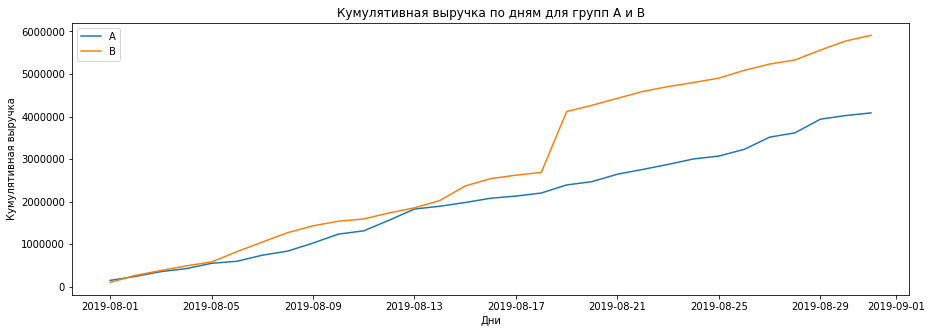

In [18]:
plt.figure(figsize=(15,5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.legend() 
plt.title('Кумулятивная выручка по дням для групп А и В')
plt.xlabel('Дни')
plt.ylabel('Кумулятивная выручка')
plt.show()

Коммулятивная выручка групп А и В растет в течении всего периода наблюдений. 19-08-2019 наблюдается резкий рост выручки группы В. Это может говорить о всплесках числа заказов или об очень дорогих заказах в данный период. 

####  Построение графика кумулятивного среднего чека по группам

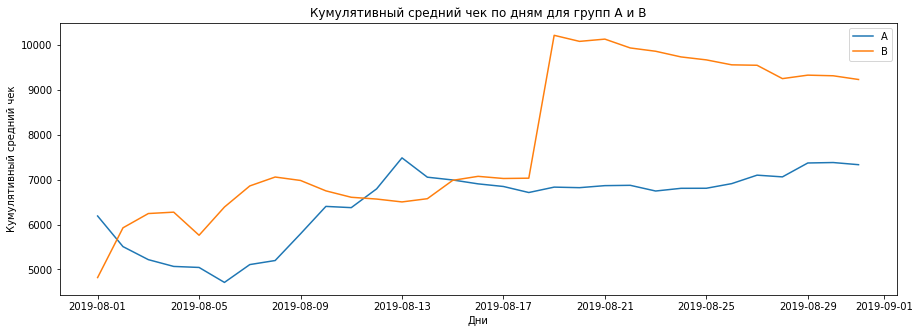

In [19]:
plt.figure(figsize=(15,5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend() 
plt.title('Кумулятивный средний чек по дням для групп А и В')
plt.xlabel('Дни')
plt.ylabel('Кумулятивный средний чек')
plt.show()

На графике также виден скачок 19-08-2019 в значениях кумулятивного среднего чека группы В, с 7000 до 10000. Это подтверждает предположение об очень дорогих заказах, совершенных в это время. После этого скачка средний чек группы В начинает падать. Средний чек группы А установился на значении 7000. До резкого скачка средний чек групп А и В были прмерно на одном уровне - 7000. Более подробное рассмотрение стоимости заказов и анализ выбросов можно посмотреть здесь: 
[Построение точечного графика стоимостей заказов](#vibros)

#### Построение графика относительного изменения кумулятивного среднего чека группы B к группе A

Создадим таблицу, объединяющую в себе кумулятивное количество заказов и кумулятивную выручку групп А и В:

In [20]:
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
display(mergedCumulativeRevenue.head())

,date,revenueA,ordersA,revenueB,ordersB
0,2019-08-01,148579,24,101217,21
1,2019-08-02,242401,44,266748,45
2,2019-08-03,354874,68,380996,61
3,2019-08-04,425699,84,489567,78
4,2019-08-05,549917,109,581995,101


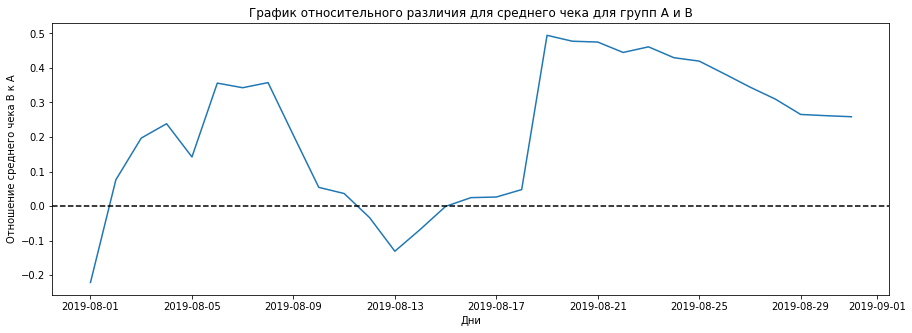

In [21]:
plt.figure(figsize=(15,5))
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
plt.axhline(y=0, color='black', linestyle='--') 
plt.title('График относительного различия для среднего чека для групп А и В')
plt.xlabel('Дни')
plt.ylabel('Отношение среднего чека В к А')
plt.show()

19-08-2019 наблюдается резкий скачок, что также говорит о крупном заказе в этот день. Далее график постепенно снижается.

#### Построение графика кумулятивной конверсии по группам

Считаем кумулятивную конверсию:

In [22]:
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

Распределяем данные по группам:

In [23]:
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

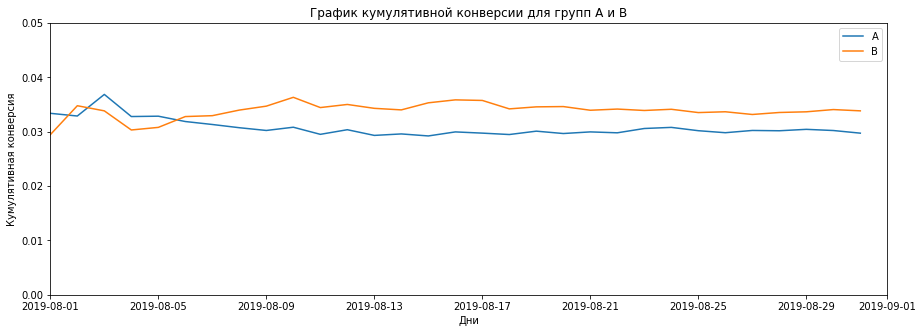

In [24]:
plt.figure(figsize=(15,5))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
plt.title('График кумулятивной конверсии для групп А и В')
plt.xlabel('Дни')
plt.ylabel('Кумулятивная конверсия')
plt.axis(["2019-08-01", '2019-09-01', 0, 0.05])
plt.show()

Конверсия группы В вырвалась вперёд и зафиксировалась, а конверсия группы А просела и также зафиксировалась примерно 2019-08-07.

#### Построение графика относительного изменения кумулятивной конверсии группы B к группе A

Создадим таблицу, объединяющую в себе кумулятивные конверсии групп А и В:

In [25]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
display(mergedCumulativeConversions.head())

,date,conversionA,conversionB
0,2019-08-01,0.033380,0.029453
1,2019-08-02,0.032885,0.034776
2,2019-08-03,0.036856,0.033833
3,2019-08-04,0.032787,0.030315
4,2019-08-05,0.032851,0.030793


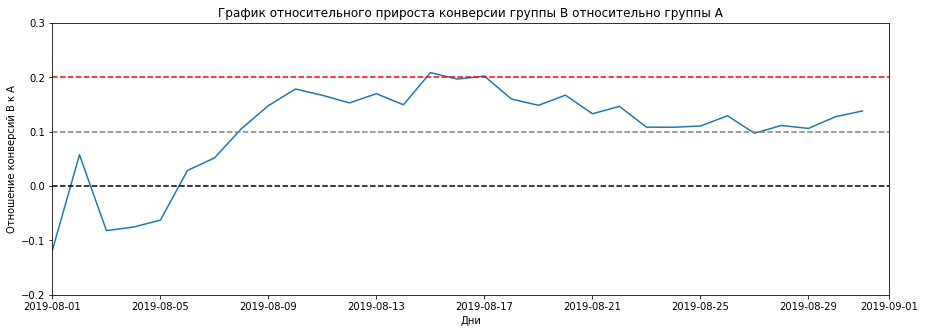

In [26]:
plt.figure(figsize=(15,5))
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.1, color='grey', linestyle='--')
plt.axhline(y=0.2, color='red', linestyle='--')
plt.axis(["2019-08-01", '2019-09-01', -0.2, 0.3]) 
plt.title('График относительного прироста конверсии группы B относительно группы A')
plt.xlabel('Дни')
plt.ylabel('Отношение конверсий В к А')
plt.show()

В начале теста группа В немного проигрывала группе А,через 5 дней группа В вырвалась вперед, и на протяжении всего теста не сдавала позиций. Больший период времени конверсия группы В больше на 10% - в конце теста этот параметр зафиксировался на этой отметке. В некоторые периоды превышение достигало 20%. 

#### Построение точечного графика количества заказов по пользователям

Создадим таблицу, содержащую количество заказов каждого клиента:

In [27]:
ordersByUsers = orders.drop(['group', 'revenue', 'date'], axis=1).groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsers.columns = ['visitorId','orders']
display(ordersByUsers.sort_values(by='orders',ascending=False).head(10))

,visitorId,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5
744,3062433592,5
55,237748145,5
917,3803269165,5
299,1230306981,5
897,3717692402,5


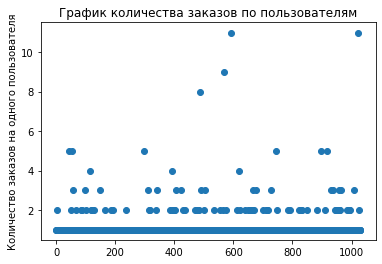

In [28]:
x_values = pd.Series(range(0,len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders'])
plt.title('График количества заказов по пользователям')
plt.ylabel('Количество заказов на одного пользователя')
plt.show()

Большинство пользователей совершают не более 3-х заказов. Есть единичные пользователи, совершившие более 8 заказов. Для дальнейшего анализа необходимо посчитать выборочные перцентили количества заказов на одного пользователя.

#### Подсчет 95-ого и 99-ого перцентилей количества заказов на пользователя

In [29]:
print(np.percentile(ordersByUsers['orders'], [95, 99])) 

[2. 4.]


Не более 5% пользователей совершали больше двух заказов, и не более 1% пользователей - больше четырех заказов. Примем за аномальных пользователей тех, кто совершил более 2-х заказов

#### Построение точечного графика стоимостей заказов<a id="vibros"></a>

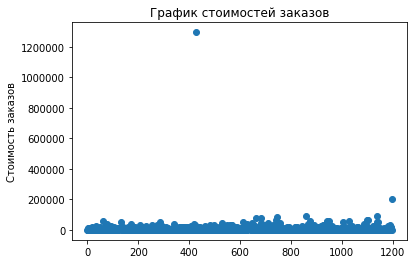

In [30]:
x_values = pd.Series(range(0,len(orders)))
plt.scatter(x_values, orders['revenue'])
plt.title('График стоимостей заказов')
plt.ylabel('Стоимость заказов')
plt.show()

In [31]:
display(orders.sort_values(by='revenue',ascending=False).head())

,transactionId,visitorId,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500,B
1196,3936777065,2108080724,2019-08-15,202740,B
858,192721366,1316129916,2019-08-27,93940,A
1136,666610489,1307669133,2019-08-13,92550,A
744,3668308183,888512513,2019-08-27,86620,B


Заказов стоимостью более 100 тыс. очень мало - всего 2, и все они как раз совершены пользователями из группы В. 19-08-2019 совершен очень дорогой заказ - 1.294.500 - этот заказ объясняет резкий скачок кумулятивного среднего чека и выручки в группе В в этот день. 

#### Подсчет 95-ого и 99-ого перцентилей стоимостей заказов

In [32]:
print(np.percentile(orders['revenue'], [95, 99]))

[28000.  58233.2]


Не более 5% пользователей совершали покупку на 28.000, и не более 1% пользователей - больше 58.233. Примем за аномальных пользователей тех, кто совершил заказ на сумму более 40.000.

#### Посчет статистической значимости различий в конверсии между группами по «сырым» данным 

Т.к. в сырых в данных есть большие (по сравнению с нормальным распределением) выбросы, выберем тест, основанный на структурном подходе - критерий Манна-Уитни. Сформулируем гипотезы: нулевая гипотеза - конверсии 2-х групп А и В равны, альтернативная гипотеза - конверсии 2-х групп А и В отличаются.

Зададим уровень статистической значимости, равный 5%:

In [33]:
alpha = .05

Сделаем срезы по группам по визитам пользователей, таблицы будут содержать данные по количеству пользователей в выбранную дату:

In [34]:
visitorsADaily = visitors[visitors['group']=='A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']
visitorsBDaily = visitors[visitors['group']=='B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

Создадим таблицы, содержащие количество пользователей до выбранной даты включительно в группах:

In [35]:
visitorsACummulative = visitorsADaily.apply(lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg({'date' : 'max', 'visitorsPerDateA' : 'sum'}), axis=1)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']
visitorsBCummulative = visitorsBDaily.apply(lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg({'date' : 'max', 'visitorsPerDateB' : 'sum'}), axis=1)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']


Сделаем срезы по группам по заказам пользователей, таблицы будут содержать данные о количестве заказов и выручке в выбранную дату:

In [36]:
ordersADaily = orders[orders['group']=='A'][['date', 'transactionId', 'visitorId', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transactionId' : pd.Series.nunique, 'revenue' : 'sum'})
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersBDaily = orders[orders['group']=='B'][['date', 'transactionId', 'visitorId', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transactionId' : pd.Series.nunique, 'revenue' : 'sum'})
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

Создадим таблицы, содержащие суммарное количество заказов до выбранной даты включительно в группах:

In [37]:
ordersACummulative = ordersADaily.apply(
    lambda x: \
        ordersADaily[ordersADaily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'ordersPerDateA' : 'sum',
                'revenuePerDateA' : 'sum'}), axis=1).sort_values(by=['date'])
ordersACummulative.columns = ['date', 'ordersCummulativeA', 'revenueCummulativeA']

ordersBCummulative = ordersBDaily.apply(
    lambda x: \
        ordersBDaily[ordersBDaily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'ordersPerDateB' : 'sum',
                'revenuePerDateB' : 'sum'}), axis=1).sort_values(by=['date'])
ordersBCummulative.columns = ['date', 'ordersCummulativeB', 'revenueCummulativeB']

Объединим все созданные таблицу в таблицу data:

In [38]:
data = ordersADaily.merge(ordersBDaily, left_on='date', right_on='date', how='left')\
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')\
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
display(data.head())

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


Сделаем срезы по группам и сгруппируем пользователям, котрые сделали хотя бы 1 заказ:

In [39]:
ordersByUsersA = orders[orders['group']=='A'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersA.columns = ['visitorId', 'orders']
ordersByUsersB = orders[orders['group']=='B'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersB.columns = ['visitorId', 'orders'] 
display(ordersByUsersA.head())
display(ordersByUsersB.head())

,visitorId,orders
0,8300375,1
1,11685486,1
2,54447517,1
3,66685450,1
4,78758296,1


,visitorId,orders
0,5114589,1
1,6958315,1
2,8300375,1
3,39475350,1
4,47206413,1


Объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули:

In [40]:
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0) 


Выведем относительный прирост конверсии группы B: конверсия группы B / конверсия группы A - 1. Округлим до трёх знаков после запятой:

In [41]:
print("{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))
print("{0:.3f}".format(sampleB.mean()/sampleA.mean()-1)) 

0.008
0.138


По «сырым» данным есть различия в конверсии групп A и B: p-value = 0.008 меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, отвергаем. Альтернативную гипотезу, о том, что есть различия в конверсиях групп - не отвергаем. Относительный выигрыш группы B равен 13.8%.

#### Подсчет статистической значимости различий в среднем чеке заказа между группами по «сырым» данным 

Сформулируем гипотезы: нулевая гипотеза - в средних чеках заказов между группами нет различий, альтернатиная гипотеза - средние чеки отличаются.

In [42]:
print("{0:.3f}".format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print("{0:.3f}".format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 


0.365
0.259


P-value значительно больше 0.05. Не отвергаем нулевую гипотезу о том, что в среднем чеке нет различий. В тоже время средний чек группы B выше среднего чека группы A на 25%.

#### Посчет статистической значимости различий в конверсии между группами по «очищенным» данным 

Учтем полученные данные об аномальных заказах (по количеству и по стоимости) и найдем количество таковых:

In [43]:
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > 2]['visitorId'], ordersByUsersB[ordersByUsersB['orders'] > 2]['visitorId']], axis = 0)
usersWithExpensiveOrders = orders[orders['revenue'] > 40000]['visitorId']
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0).drop_duplicates().sort_values()
display(abnormalUsers.head(5))
print('Количество аномальных пользователей:', abnormalUsers.shape) 

1099    148427295
18      199603092
23      237748145
37      249864742
684     358944393
Name: visitorId, dtype: int64

Количество аномальных пользователей: (45,)


Подготовим выборки количества заказов по пользователям по группам теста без аномальных пользователей:

In [44]:
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))]['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])),name='orders')],axis=0)
sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))]['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])),name='orders')],axis=0) 

Применим статистический критерий Манна-Уитни к полученным выборкам:

In [45]:
print("{0:.3f}".format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print("{0:.3f}".format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

0.003
0.188


p-value = 0.003 меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, отвергаем. Альтернативную гипотезу, о том. что между конверсиями групп есть различия - не отвергаем. Относительный выигрыш группы B равен 18.8% - по сравнению с "сырыми данными" выигрыш увеличился.

#### Посчет статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным 

In [46]:
print("{0:.3f}".format(stats.mannwhitneyu(
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'],
    orders[np.logical_and(
        orders['group']=='B',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'])[1]))

print("{0:.3f}".format(
    orders[np.logical_and(orders['group']=='B',np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean()/
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean() - 1)) 


0.472
0.058


P-value значительно больше 0.05. Не отвергаем нулевую гипотезу о том, что в среднем чеке нет различий. Средний чек группы B выше среднего чека группы A на 5,8%, что значительно меньше 25%, полученных по сырым данным.

## 4.Вывод<a id="conclusion"></a>

* есть статистически значимые различия по конверсии между группами и по «сырым» (В больше А на 13,8%), и по данным после фильтрации аномалий (В больше А на 18,8%)
* по графику различия конверсий между группами также видно, что конверсия группы В больше группы А на 10-20% 
* нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий, по очищенным данным средний чек группы В больше среднего чека группы А на 5,8%
* график среднего чека неравномерен, бывают периоды когда группа В превышает группу А, а бывает наоборот. Во второй половине исследуемого периода, средний чек группы В значительно выше среднего чека группы А, но данная разница сокращается
* т.к. данные по конверсии показывают преимущество группы В, а средний чек на данный момент - не показывает значительного преимущества группы В, я бы рекомендовала продолжть тест. Если же основной целью тестирования была проверка показателя конверсии - то данный тест можно остановить, и зафиксировать победу группы В
* проверяя приоритезацию гипотез методами ICE и RICE были обнаружены различия в результатах. Т.к. метод RICE учитывает дополнительную важную характеристику - охват пользователей, данные полученные этим фрэймворком я считаю более достоверными: приоритетна гипотеза №7 "Добавить форму подписки на все основные страницы".